<a href="https://colab.research.google.com/github/semthedev/ml-course-2025/blob/main/homeworks/8_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07. Case study: non-gaussian noise

In [ ]:
!pip install jupyter_black

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.6 MB/s eta 0:00:00


In [ ]:
%load_ext jupyter_black

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression

Сначала немного вспомним, какие вероятностные предположнеия мы делали в обычной регрессии.

Собственно, линейная зависимость $\mathbf{y}$ от $\mathbf{x}$:

$$y(\mathbf{x}, \mathbf{w}) = \sum_{j=0}^{M-1}{w_j x_j} = \mathbf{w}^T \mathbf{x} \tag{1}$$

Далее, говорим что в настоящих данных метки с шумом:
$$
t = y(\mathbf{x}, \mathbf{w}) + \epsilon \tag{2}
$$

Который (важно):
1. Имеет нормальное распределение с нулевым средним
2. Гомоскедастичен (то есть, не зависит от x)
3. Независим в совокупности (то есть, шум в каждой точке данных - множество независимых в совокупности с.в.)

Правдоподобие одной точки данных:
$$
p(t \lvert \mathbf{x}, \mathbf{w}, \beta) =
\mathcal{N}(t \lvert y(\mathbf{x}, \mathbf{w}), \beta^{-1}) =
\sqrt{\beta \over {2 \pi}} \exp\left(-{\beta \over 2} (t - y(\mathbf{x}, \mathbf{w}))^2 \right) \tag{3}
$$

Наконец, полное правдоподобие:

$$
p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) =
\prod_{i=1}^{N}{\mathcal{N}(t_i \lvert \mathbf{w}^T \mathbf{x_i}, \beta^{-1})} \tag{4}
$$



Помните полиномиальную регрессию с лекций, где в качестве $X$ мы подставляли степени одной-единственной независимой переменной $x$? Так вот, в литературе такой трюк называется **design matrix**, и конечно вместо степеней можно подставлять абсолютно что угодо.

$$
\boldsymbol\Phi =
\begin{pmatrix}
\phi_0(\mathbf{x}_1) &  \phi_1(\mathbf{x}_1) & \cdots & \phi_{M-1}(\mathbf{x}_1) \\
\phi_0(\mathbf{x}_2) &  \phi_1(\mathbf{x}_2) & \cdots & \phi_{M-1}(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\mathbf{x}_N) &  \phi_1(\mathbf{x}_N) & \cdots & \phi_{M-1}(\mathbf{x}_N)
\end{pmatrix} \tag{7}
$$


В большинстве случаев предположение о том, что шум имеет нормальное распределение - абсолютно логичное, благодаря ЦПТ. Но там, где условия ЦПТ нарушаются (какие там условия, кстати? а кто может привести пример?), возникают другие респределения.

Например, экспоненциальное распределение - это распределение интервалов между равномерно распределенными с.в. Так что если, например, вы измеряете время какого-то процесса, и оно замеряется с задержкой - вы получите экспоненциальный шум. В жизни экспоненциальное респределение имеют, например, паузы между щелчками счетчика Гейгера.

# Синтетические данные

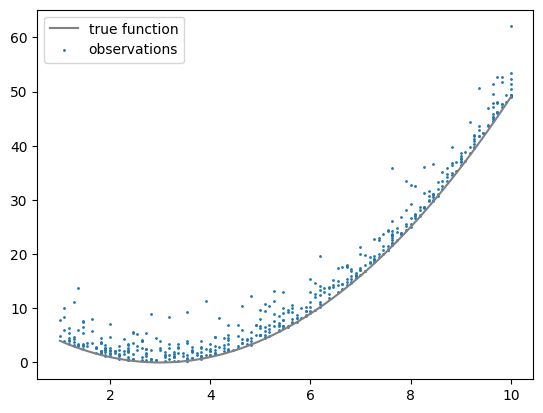

In [ ]:
def f_true(x):
    return (x - 3) ** 2


x = np.linspace(1, 10, 100)
x_observed = np.random.choice(x, size=500, replace=True)
y_observed = f_true(x_observed) + np.random.exponential(2.0, len(x_observed))

plt.plot(x, f_true(x), c="grey", label="true function")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

# Обычная регресссия

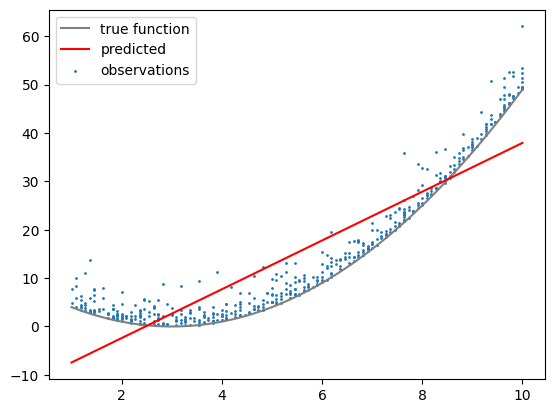

In [ ]:
from sklearn.linear_model import LinearRegression

# обучаем обычную линейную регрессию (признак один, поэтому reshape)
regr = LinearRegression()
regr.fit(x_observed.reshape(-1, 1), y_observed)

# предсказываем на всей сетке x
y_pred = regr.predict(x.reshape(-1, 1))

# рисунок
plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, y_pred, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

# Обычная регресссия + полиномиальный базис

In [ ]:
def get_design(x):
    x = np.asarray(x)
    return np.column_stack(
        [
            np.ones_like(x),  # φ0(x) = 1
            x,  # φ1(x) = x
            x**2,  # φ2(x) = x^2
        ]
    )


get_design(np.array([1, 2, 3]))

array([[1, 1, 1],
       [1, 2, 4],
       [1, 3, 9]])

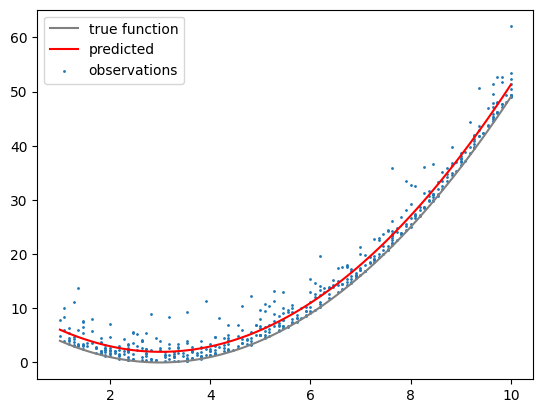

In [ ]:
regr = LinearRegression()
regr.fit(get_design(x_observed), y_observed)
y_pred = regr.predict(get_design(x))

plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, y_pred, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

# Линейная регрессия с экспоненциальным распределением шума

In [ ]:
from tqdm.notebook import tqdm


def log_likelihood(X, y, W, _lambda=1):
    """
    PDF: lambda * exp (-lambda * x)

    :param X_data: observable features with (bias term at first coordinate)
                    expected shape: (n_samples, n_features + 1)
    :param y: observable target
                    expected shape: (n_samples)
    :param W: weight matrix (with bias term at first coordinate):
                    expexted_shape: (n_features + 1, )
    """

    residuals = y - X @ W
    if np.any(residuals < 0):
        return -np.inf
    return np.sum(np.log(_lambda) - _lambda * residuals)


def add_bias_to_features(X):
    X = np.concatenate([np.ones_like(X)[:, 0:1], X], axis=-1)
    return X


X = add_bias_to_features(x_observed[:, None])

print("Negative Log Likelihood:", -log_likelihood(X, y_observed, np.zeros(2)))

Negative Log Likelihood: 7498.007436244086


Как вы наверное помните с лекций, максимизация полного правдоподобия линейной модели **с нормальным шумом** - это в точности минимизация суммы квадратов отклонений, а еще для нее можно провести честный байесовский вывод.

С другим распроеделением шума, оба утверждения неверны. Во-первых, оптимизировать надо иначе (почему?), во-вторых вывести ничего не выйдет.

In [ ]:
W = np.zeros(X.shape[-1]).T

...

print("Negative Log Likelihood:", likelihood)
print("Optimum:", W_optimal)
plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, add_bias_to_features(x[:, None]) @ W_optimal, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

NameError: name 'likelihood' is not defined

In [ ]:
ax = sns.heatmap(grid_values, cmap="coolwarm", center=grid_values.mean())
x_ticks = np.arange(slices[0].start, slices[0].stop, slices[0].step)
y_ticks = np.arange(slices[1].start, slices[1].stop, slices[1].step)
ax.set_xticks(np.linspace(0, len(x_ticks) - 1, num=6))  # Adjust the number of ticks
ax.set_yticks(np.linspace(0, len(y_ticks) - 1, num=6))
ax.set_xticklabels(
    [f"{tick:.1f}" for tick in np.linspace(slices[0].start, slices[0].stop, num=6)]
)
ax.set_yticklabels(
    [f"{tick:.1f}" for tick in np.linspace(slices[1].start, slices[1].stop, num=6)]
)
ax.set_title("Negative Log-Likelihood Heatmap")

y_idx = int((W_optimal[0] - slices[0].start) / slices[0].step)
x_idx = int((W_optimal[1] - slices[1].start) / slices[1].step)
plt.scatter(x_idx, y_idx, marker="*", color="red", s=200, label="W_optimal")
plt.legend()
plt.show()

# Экспоненциальный шум + полиномиальный базис

In [ ]:
X = add_bias_to_features(get_design(x_observed))
W = np.ones(X.shape[-1]).T

...

print("Negative Log Likelihood:", likelihood)

In [ ]:
print("Optimum:", W_optimal)
plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, add_bias_to_features(get_design(x)) @ W_optimal, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()

# Case study: Robust linear regression

Предыдущий пример был интересный концептуально, но на самом-то деле не очень практичный. Теперь более практичный сюжет:



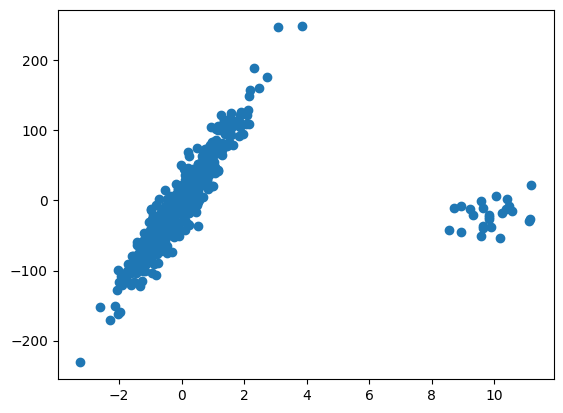

In [ ]:
# снова сгенерированные даные

N_SAMPLES = 500
N_OUTLIERS = 25

X, y, coef = datasets.make_regression(
    n_samples=N_SAMPLES,
    n_features=1,
    n_informative=1,
    noise=20,
    coef=True,
    random_state=42,
)

coef_list = [["original_coef", float(coef)]]

# add outliers
np.random.seed(42)
X[:N_OUTLIERS] = 10 + 0.75 * np.random.normal(size=(N_OUTLIERS, 1))
y[:N_OUTLIERS] = -15 + 20 * np.random.normal(size=N_OUTLIERS)

plt.scatter(X, y);

Казалось бы, есть линейная модель, есть данные которые явно имеют линейную природу. Ну добавили к ним 5% каких-то выбросов, что может пойти не так?

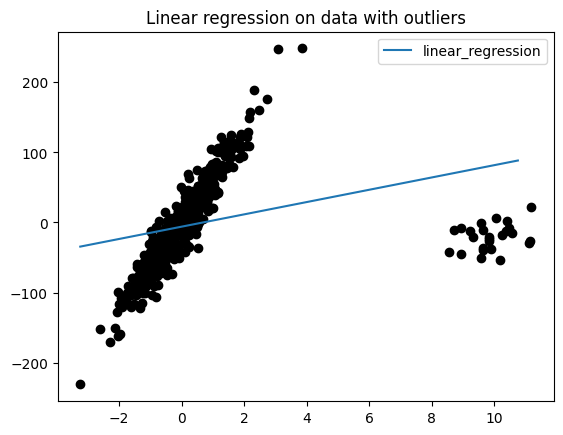

In [ ]:
lr = LinearRegression().fit(X, y)
coef_list.append(["linear_regression", lr.coef_[0]])

plotline_X = np.arange(X.min(), X.max()).reshape(-1, 1)
fit_df = pd.DataFrame(
    index=plotline_X.flatten(), data={"linear_regression": lr.predict(plotline_X)}
)

fix, ax = plt.subplots()
fit_df.plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("Linear regression on data with outliers");

### И что теперь делать?

Есть целое семейство линейных моделей, которые менее чувствительны к выбросам. Про какие-то из них (Huber, RANSAC) мы поговорим через одно занятие, а сегодня придумаем что-нибудь на коленке. Что предложите?

In [ ]:
from scipy.stats import t
from scipy.optimize import minimize


# X: (n_samples, 1)
# y: (n_samples,)
# w: (2,) = [slope, intercept]
def log_likelihood(X, y, w, df=1):
    # берем одномерный вектор признака
    x_vec = X[:, 0]  # shape (n_samples,)
    # линейная модель: y_hat = w0 * x + w1
    y_hat = x_vec * w[0] + w[1]
    # остатки
    residuals = y - y_hat
    # логарифм правдоподобия при t-шуме
    return t.logpdf(residuals, df=df).sum()


# пробный вызов, просто чтобы увидеть значение
print(
    "Test log-likelihood:",
    log_likelihood(X, y, np.array([0.0, 100.0]), df=1),
)

Test log-likelihood: -4965.925392827561


In [ ]:
df = 1  # degrees of freedom для t-распределения


def objective(w):
    # минимизируем отрицательное лог-правдоподобие
    return -log_likelihood(X, y, w, df=df)


# стартовая точка (наклон=0, сдвиг=0)
w0 = np.array([0.0, 0.0])

res = minimize(objective, x0=w0)
res  # в ноутбуке можно просто вывести, чтобы посмотреть

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 4041.9559736029305
        x: [-7.334e-01 -4.604e+00]
      nit: 11
      jac: [ 3.052e-05  0.000e+00]
 hess_inv: [[ 4.439e-03 -1.004e-02]
            [-1.004e-02  3.379e-02]]
     nfev: 162
     njev: 50

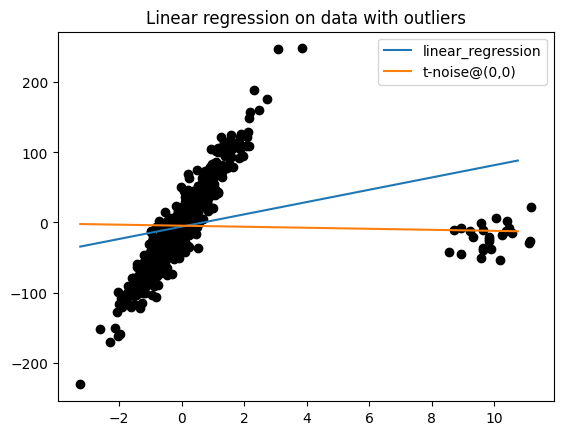

In [ ]:
## ...но есть нюанс

# Добавляем в fit_df ещё одну линию – t-регрессию
fit_df["t-noise@(0,0)"] = pd.DataFrame(
    index=plotline_X.flatten(),
    data={"t-noise@(0,0)": plotline_X[:, 0] * res.x[0] + res.x[1]},
)

fig, ax = plt.subplots()
fit_df.plot(ax=ax)  # нарисует linear_regression и t-noise@(0,0)
plt.scatter(X, y, c="k")
plt.title("Linear regression on data with outliers")
plt.show()

#### Задача со звездочкой 8:
Экспоненциальный шум (2 балла)
Придумать и реализовать более умную оптимизацию линейной регрессии с экспоненциальным шумом, чем полным перебором по пространству весов. Правильный ответ должен быть **неотличим на глаз** от предсказаний модели.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# 1) Строим дизайн-матрицу для линейной модели: y ≈ w0 + w1 * x
X = add_bias_to_features(x_observed[:, None])
y = y_observed

In [ ]:
# 2) Целевая функция LP
# Хотим max 1^T X w   =>   min c^T w, где c = -1^T X
c = -(X.T @ np.ones(X.shape[0]))  # shape: (2,)

# 3) Ограничения: X w <= y
A_ub = X  # (N, 2)
b_ub = y  # (N,)

# 4) Решаем LP. HiGHS умеет неограниченные переменные, поэтому bounds не задаём.
res_lp = linprog(
    c=c,
    A_ub=A_ub,
    b_ub=b_ub,
    method="highs",
)

print("LP success:", res_lp.success, "|", res_lp.message)
w_exp = res_lp.x
print("Оптимальные веса (exp-noise MLE):", w_exp)

LP success: True | Optimization terminated successfully. (HiGHS Status 7: Optimal)
Оптимальные веса (exp-noise MLE): [0.         0.08323897]


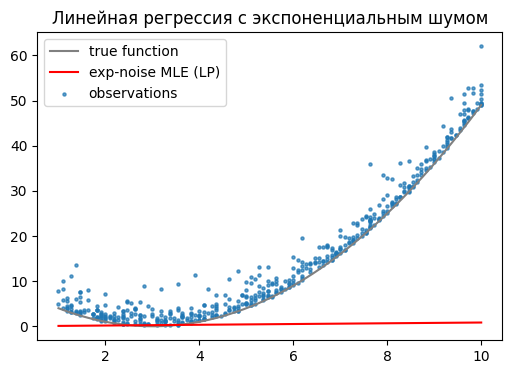

In [ ]:
# 5) Визуализация результата

x_grid = np.linspace(x_observed.min(), x_observed.max(), 400)
X_grid = add_bias_to_features(x_grid[:, None])

plt.figure(figsize=(6, 4))
plt.plot(x_grid, f_true(x_grid), c="grey", label="true function")
plt.plot(x_grid, y_pred_exp, c="red", label="exp-noise MLE (LP)")
plt.scatter(x_observed, y_observed, s=5, alpha=0.7, label="observations")
plt.legend()
plt.title("Линейная регрессия с экспоненциальным шумом")
plt.show()

Negative Log Likelihood (smart optimization): 1702.8702734803833
Optimal weights (Laplace MLE): [-13.24287012   4.90927377]
success: True


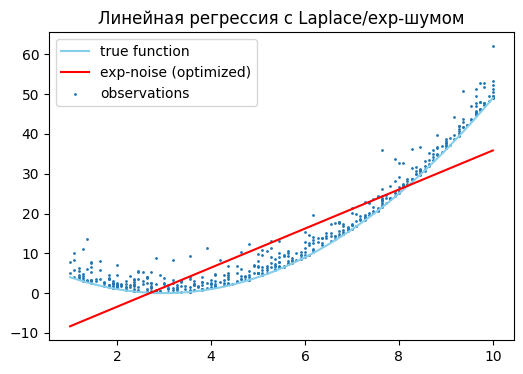

In [ ]:
# более умная оптимизация для линейной регрессии с экспоненциальным (Laplace) шумом

lambda_exp = 0.5  # параметр распределения (как раньше)


def log_likelihood_exp(X, y, W, _lambda=lambda_exp):
    """
    Лог-правдоподобие при двустороннем экспоненциальном (Laplace) шуме:
    p(e) = (_lambda / 2) * exp(-_lambda * |e|)
    e = y - X @ W
    """
    y_pred = X @ W  # предсказания модели
    residuals = y - y_pred  # остатки
    return np.sum(np.log(_lambda) - _lambda * np.abs(residuals))


# матрица признаков с bias-столбцом
X_exp = add_bias_to_features(x_observed[:, None])

# стартовая точка — решение обычной линейной регрессии (OLS)
ols = LinearRegression().fit(x_observed[:, None], y_observed)
W_init = np.array([ols.intercept_, ols.coef_[0]])


def objective(W):
    # минимизируем отрицательное лог-правдоподобие
    return -log_likelihood_exp(X_exp, y_observed, W, _lambda=lambda_exp)


# численная оптимизация по весам W
res = scipy.optimize.minimize(
    objective,
    x0=W_init,
    method="Nelder-Mead",
)

W_exp_optimal = res.x
neg_log_like = res.fun

print("Negative Log Likelihood (smart optimization):", neg_log_like)
print("Optimal weights (Laplace MLE):", W_exp_optimal)
print("success:", res.success)

# рисуем
x_grid = np.linspace(x_observed.min(), x_observed.max(), 400)
X_grid = add_bias_to_features(x_grid[:, None])
y_pred_exp = X_grid @ W_exp_optimal

plt.figure(figsize=(6, 4))
plt.plot(x_grid, f_true(x_grid), c="skyblue", label="true function")
plt.plot(x_grid, y_pred_exp, c="red", label="exp-noise (optimized)")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()
plt.title("Линейная регрессия с Laplace/exp-шумом")
plt.show()

#### Задача со звездочкой 9: Эллипс

Вы оказались одни в лесу, и вам очень надо восстановить уравнение эллипса по данным. Как на зло, все что у вас есть - это `sklearn.linear_model.LinearRegression`.

**1 балл.** К счастью, вы знаете что эллипс не абы какой, а с осями, параллельными осям координат.

**1 балл.** А теперь не знаете. (WARNING: я не уверен в том, что это возможно c `LinearRegression`, но OLS может)

In [ ]:
# Правильный ответ
CENTER_X = -5.0
CENTER_Y = 2.0
SCALE_X = 2.0
SCALE_Y = 3.0
ANGLE = np.pi / 6

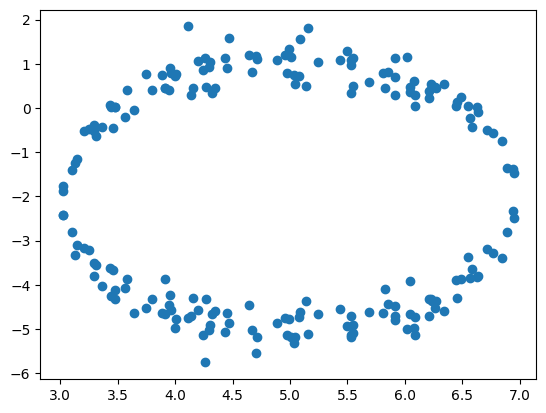

In [ ]:
# Генерируем данные
x = np.random.rand(100) * 2 - 1
y_pos = np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y_neg = -np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y = np.hstack([y_pos, y_neg])
x = x * SCALE_X - CENTER_X
y = y * SCALE_Y - CENTER_Y
x = np.hstack([x, x])
data = np.stack([x, y], axis=1)
plt.scatter(data[:, 0], data[:, 1])

Оценённые коэффициенты (A,B,C,D,F):
-0.04352581410399947 -0.014032103889845327 0.4358746542929054 -0.05618667195589683 -1.0

Оценённый центр (геометрический): 5.007082156481181 -2.0020758254418882
Оценённые полуоси a, b: 1.8407121741853731 3.241887503906232

Сравнение с правильным ответом.
истинный центр: 5.0 -2.0
истинные полуоси: 2.0 3.0


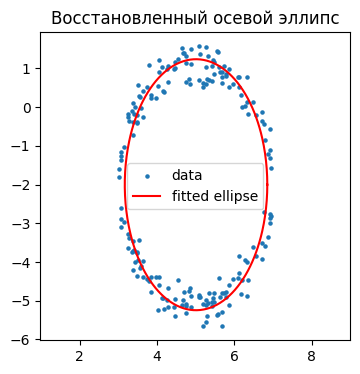

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1) Линейная регрессия для уравнения эллипса
# Хотим модель вида:  A x^2 + B y^2 + C x + D y + F = 0.
# Зафиксируем F = -1 и перепишем:
# A x^2 + B y^2 + C x + D y - 1 = 0  <=>  1 ≈ A x^2 + B y^2 + C x + D y
# Это уже обычная линейная регрессия БЕЗ интерсепта.

X_feat = np.column_stack(
    [
        data[:, 0] ** 2,  # x^2
        data[:, 1] ** 2,  # y^2
        data[:, 0],  # x
        data[:, 1],  # y
    ]
)
target = np.ones(len(data))

reg = LinearRegression(fit_intercept=False)
reg.fit(X_feat, target)

A, B, C, D = reg.coef_
F = -1.0

print("Оценённые коэффициенты (A,B,C,D,F):")
print(A, B, C, D, F)

# 2) Восстановление центра и полуосей (ось-параллельный эллипс)
# Общее уравнение: A x^2 + B y^2 + C x + D y + F = 0.
# Сдвигаем к центру и дополняем квадрат:
# cx = -C / (2A),  cy = -D / (2B)
# K = -F + C^2/(4A) + D^2/(4B)
# A (x-cx)^2 + B (y-cy)^2 = K
# => (x-cx)^2 / (K/A) + (y-cy)^2 / (K/B) = 1
# => a^2 = K / A,  b^2 = K / B

cx_hat = -C / (2 * A)
cy_hat = -D / (2 * B)
K = -F + C**2 / (4 * A) + D**2 / (4 * B)

a_hat = np.sqrt(K / A)
b_hat = np.sqrt(K / B)

print("\nОценённый центр (геометрический):", cx_hat, cy_hat)
print("Оценённые полуоси a, b:", a_hat, b_hat)

print("\nСравнение с правильным ответом.")
print("истинный центр:", -CENTER_X, -CENTER_Y)
print("истинные полуоси:", SCALE_X, SCALE_Y)

# 3) Визуализация восстановленного эллипса
theta = np.linspace(0, 2 * np.pi, 400)
x_ellipse = cx_hat + a_hat * np.cos(theta)
y_ellipse = cy_hat + b_hat * np.sin(theta)

plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], s=5, label="data")
plt.plot(x_ellipse, y_ellipse, c="red", label="fitted ellipse")
plt.axis("equal")
plt.legend()
plt.title("Восстановленный осевой эллипс")
plt.show()

---
This notebook is based on Nvidia [article](https://github.com/erykml/nvidia_articles/blob/main/robust_regression.ipynb) on robust regression.